# **DATA LOADING AND NORMALIZATION**

In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.9 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from PIL import Image
import torch
import torch.nn.functional as F
from torch.optim import AdamW
from sklearn.metrics import precision_score, recall_score
from torchsummary import summary
import math

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from tqdm import tqdm
labels = ['NORMAL', 'PNEUMONIA']
img_size = 224


def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        #print(path)
        class_num = labels.index(label)

        for i, img in enumerate(tqdm(os.listdir(path))):
            try:
                # Load and resize the image
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))  # Resize the image

                # Add the image and label as a pair
                data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error loading image {img}: {e}")


    # Convert the list to a NumPy array
    data = np.array(data, dtype=object)  # Use dtype=object to allow image-label pairing
    return data

# Load the data
train_data = get_training_data('/content/drive/MyDrive/normData/train')
test_data = get_training_data('/content/drive/MyDrive/normData/test')
val_data = get_training_data( '/content/drive/MyDrive/normData/val')

100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


## **DATA Preparation**

Count of label 0: 3875
Count of label 1: 3945
Count of label 0: 8
Count of label 1: 8
Shape of train images: (7820, 224, 224)
Shape of validation images: (16, 224, 224)


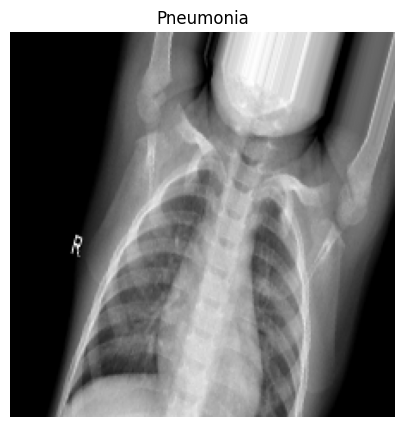

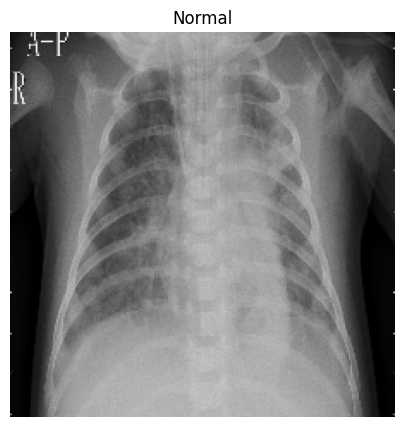

In [5]:
#Separate the images and the labels
train_images_display = np.array([x[0] for x in train_data])  # Extract only the images
train_labels_display = np.array([x[1] for x in train_data])  # Extract only the labels

# Initialize counts for each label
count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in train_labels_display:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")

val_images_display = np.array([x[0] for x in val_data])  # Extract only the images
val_labels_display = np.array([x[1] for x in val_data])  # Extract only the labels

count_0 = 0
count_1 = 0

# Loop through the labels and count occurrences
for label in val_labels_display:
    if label == 0:
        count_0 += 1
    elif label == 1:
        count_1 += 1

# Print the results
print(f"Count of label 0: {count_0}")
print(f"Count of label 1: {count_1}")

test_images_display = np.array([x[0] for x in test_data])  # Extract only the images
test_labels_display = np.array([x[1] for x in test_data])  # Extract only the labels

# Check the shape and an example of the dataset
print(f"Shape of train images: {train_images_display.shape}")
print(f"Shape of validation images: {val_images_display.shape}")

# Display the first image from the training data
plt.figure(figsize=(5, 5))
plt.imshow(train_images_display[0], cmap='gray')
plt.title('Pneumonia' if train_labels_display[0] == 0 else 'Normal')
plt.axis('off')
plt.show()

# Display the last image from the validation data
plt.figure(figsize=(5, 5))
plt.imshow(val_images_display[-1], cmap='gray')
plt.title('Pneumonia' if val_labels_display[-1] == 0 else 'Normal')
plt.axis('off')
plt.show()

### Normalize Images

In [6]:
# Function to normalize the images
def normalize_images(data):
    images = []
    labels = []

    for img, label in tqdm(data):
        # Normalization: each pixel is divided by 255
        normalized_img = img / 255.0
        images.append(normalized_img)
        labels.append(label)

    # Convert the images and labels into separate arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Normalize the images in the training dataset
train_images, train_labels = normalize_images(train_data)
val_images, val_labels = normalize_images(val_data)
test_images, test_labels = normalize_images(test_data)


# Check the shape and an example of the normalized and shuffled data
print(f"Shape of normalized and shuffled test images: {test_images.shape}")
print(f"Shape of normalized and shuffled train images: {train_images.shape}")
print(f"Shape of normalized and shuffled validation images: {val_images.shape}")

100%|██████████| 624/624 [00:00<00:00, 3668.47it/s]


Shape of normalized and shuffled test images: (624, 224, 224)
Shape of normalized and shuffled train images: (7820, 224, 224)
Shape of normalized and shuffled validation images: (16, 224, 224)


### Create Dataloaders

In [58]:
from torch.utils.data import TensorDataset, DataLoader

# Convert the images and labels to PyTorch tensors

# Apply the transformation to training and validation images
train_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in train_images]).unsqueeze(1)
train_images_tensor = torch.flatten(train_images_tensor, start_dim=2)
val_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in val_images]).unsqueeze(1)
val_images_tensor = torch.flatten(val_images_tensor, start_dim=2)
test_images_tensor = torch.stack([torch.tensor(img, dtype=torch.float) for img in test_images]).unsqueeze(1)
test_images_tensor = torch.flatten(test_images_tensor, start_dim=2)

# Now permute them
train_images_tensor = train_images_tensor.permute(0, 1, 2)  # (N, 1, 244 x 244)
val_images_tensor = val_images_tensor.permute(0, 1, 2)      # (N, 1, 244 x 244)
test_images_tensor = test_images_tensor.permute(0, 1, 2)    # (N, 1, 244 x 244)
print(train_images_tensor.shape, val_images_tensor.shape, test_images_tensor.shape)

# The tensors are now in the shape (N, 1, 244, 244), where N is the number of images

train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

# Create the dataset and DataLoader
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_images_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)

# Define the batch size
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)


print('Done!')

torch.Size([7820, 1, 50176]) torch.Size([16, 1, 50176]) torch.Size([624, 1, 50176])
Done!


In [55]:
# Now the data is ready for training and validation
class KANLinear_v1(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True, base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear_v1, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = ((torch.arange(-spline_order, grid_size + spline_order + 1) * h
                 + grid_range[0]).expand(in_features, -1).contiguous())
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = ((torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 0.5)
                     * self.scale_noise / self.grid_size)
            self.spline_weight.data.copy_(
                self.scale_spline * self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise)
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x):
        grid = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, :-(k+1)]) / (grid[:, k:-1] - grid[:, :-(k+1)]) * bases[:, :, :-1]
                     + (grid[:, k+1:] - x) / (grid[:, k+1:] - grid[:, 1:-k]) * bases[:, :, 1:])
        return bases.contiguous()

    def curve2coeff(self, x, y):
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        return solution.permute(2, 0, 1).contiguous()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.spline_weight.view(self.out_features, -1)
        )
        return base_output + spline_output

class Linear_KAN(torch.nn.Module):
    def __init__(self, parameters_list):
        super(Linear_KAN, self).__init__()
        self.layer1 = torch.nn.Linear(parameters_list[0], parameters_list[1])
        self.bn1 = torch.nn.BatchNorm1d(1)
        self.relu1 = torch.nn.ReLU()
        self.layer2 = KANLinear_v1(parameters_list[1], parameters_list[2], grid_size=16)
        self.layer3 = KANLinear_v1(parameters_list[2], parameters_list[3], grid_size=16)
        self.softmax = torch.nn.Softmax(dim=1)
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = torch.squeeze(x, dim=1)
        x = self.softmax(x)
        return x
# Define model
model   = Linear_KAN([224 * 224, 512, 256, 2])
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda


Linear_KAN(
  (layer1): Linear(in_features=50176, out_features=512, bias=True)
  (bn1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (layer2): KANLinear_v1(
    (base_activation): SiLU()
  )
  (layer3): KANLinear_v1(
    (base_activation): SiLU()
  )
  (softmax): Softmax(dim=1)
)

In [56]:
from torchmetrics import Recall, Precision

criterion = torch.nn.CrossEntropyLoss()  # For multi-class or binary classification
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)  # AdamW with L2 regularization

# Now the data is ready for training and validation

# Function to calculate relevant metrics

# Training function with Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=20):
    patience_counter = 0
    best_validation_f1 = 0
    best_validation_recall = 0
    best_validation_precision = 0
    losses = []
    f1s = []
    recalls = []
    precisions = []
    for epoch in range(num_epochs):
        model.train()
        p_bar = tqdm(train_loader)
        running_loss = 0

        for i, (images, labels) in enumerate(p_bar):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            p_bar.set_description(f"Epoch {epoch+1}/{num_epochs} - Loss: {(running_loss / (i + 1)):.4f}")
        losses.append(running_loss / len(train_loader))

        if (epoch + 1) % 1 == 0:
            recall_score_metric = Recall(task='binary')
            precision_score_metric = Precision(task='binary')
            model.eval()
            p_bar = tqdm(val_loader)
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for i, (images, labels) in enumerate(p_bar):
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, preds = torch.max(outputs, 1)
                    all_preds.extend(preds.cpu())
                    all_labels.extend(labels.cpu())
                    p_bar.set_description(f'Epoch {epoch+1}/{num_epochs} - Validation Batch: {i}')

            all_preds = torch.tensor(all_preds, dtype=torch.float32)
            all_labels = torch.tensor(all_labels, dtype=torch.long)
            precision = precision_score_metric(all_labels, all_preds)
            recall = recall_score_metric(all_labels, all_preds)
            f1 = 2 * (precision * recall)/(precision + recall)

            f1s.append(f1)
            recalls.append(recall)
            precisions.append(precision)

            print(f"Epoch {epoch+1}/{num_epochs} - Validation F1 Score: {f1:.4f} - Validation Recall Score: {recall:.4f} - Validation Precision Score: {precision:.4f}")
            if f1 > best_validation_f1:
                best_validation_f1 = f1
                best_validation_precision = precision
                best_validation_recall = recall
                patience_counter = 0
                print('Exceeded')
                #torch.save(model.state_dict(), os.path.join('/content/drive/MyDrive/model_results', 'best_model_resnet.pth'))

            else:
                patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
    return losses, f1s, recalls, precisions, best_validation_f1, best_validation_precision, best_validation_recall

# Start training
losses, f1s, recalls, precisions, f1, precision, recall = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, patience=10)
print(f'Best F1: {f1}, Precision: {precision}, Recall: {recall}')
print('Losses: ', losses)
print('F1s', f1s)
print('Recalls: ', recalls)
print('Precisons: ', precisions)

Epoch 1/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 122.75it/s]


Epoch 1/100 - Validation F1 Score: 0.7273 - Validation Recall Score: 0.5714 - Validation Precision Score: 1.0000
Exceeded


Epoch 2/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 185.59it/s]


Epoch 2/100 - Validation F1 Score: 0.8000 - Validation Recall Score: 0.6667 - Validation Precision Score: 1.0000
Exceeded


Epoch 3/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 148.11it/s]


Epoch 3/100 - Validation F1 Score: 0.8000 - Validation Recall Score: 0.6667 - Validation Precision Score: 1.0000


Epoch 4/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 134.94it/s]


Epoch 4/100 - Validation F1 Score: 0.7619 - Validation Recall Score: 0.6154 - Validation Precision Score: 1.0000


Epoch 5/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 199.46it/s]


Epoch 5/100 - Validation F1 Score: 0.8000 - Validation Recall Score: 0.6667 - Validation Precision Score: 1.0000


Epoch 6/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 165.70it/s]


Epoch 6/100 - Validation F1 Score: 0.7273 - Validation Recall Score: 0.5714 - Validation Precision Score: 1.0000


Epoch 7/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 159.10it/s]


Epoch 7/100 - Validation F1 Score: 0.8889 - Validation Recall Score: 0.8000 - Validation Precision Score: 1.0000
Exceeded


Epoch 8/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 171.92it/s]


Epoch 8/100 - Validation F1 Score: 0.7692 - Validation Recall Score: 1.0000 - Validation Precision Score: 0.6250


Epoch 9/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 129.75it/s]


Epoch 9/100 - Validation F1 Score: 0.8421 - Validation Recall Score: 0.7273 - Validation Precision Score: 1.0000


Epoch 10/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 176.74it/s]


Epoch 10/100 - Validation F1 Score: 0.7692 - Validation Recall Score: 1.0000 - Validation Precision Score: 0.6250


Epoch 11/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 158.90it/s]


Epoch 11/100 - Validation F1 Score: 0.8889 - Validation Recall Score: 0.8000 - Validation Precision Score: 1.0000


Epoch 12/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 167.02it/s]


Epoch 12/100 - Validation F1 Score: 0.7273 - Validation Recall Score: 0.5714 - Validation Precision Score: 1.0000


Epoch 13/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 216.23it/s]


Epoch 13/100 - Validation F1 Score: 0.8000 - Validation Recall Score: 0.8571 - Validation Precision Score: 0.7500


Epoch 14/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 130.96it/s]


Epoch 14/100 - Validation F1 Score: 0.7619 - Validation Recall Score: 0.6154 - Validation Precision Score: 1.0000


Epoch 15/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 210.32it/s]


Epoch 15/100 - Validation F1 Score: 0.8421 - Validation Recall Score: 0.7273 - Validation Precision Score: 1.0000


Epoch 16/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 178.58it/s]


Epoch 16/100 - Validation F1 Score: 0.8421 - Validation Recall Score: 0.7273 - Validation Precision Score: 1.0000


Epoch 17/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 202.17it/s]


Epoch 17/100 - Validation F1 Score: 0.9412 - Validation Recall Score: 0.8889 - Validation Precision Score: 1.0000
Exceeded


Epoch 18/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 164.51it/s]


Epoch 18/100 - Validation F1 Score: 0.8000 - Validation Recall Score: 0.6667 - Validation Precision Score: 1.0000


Epoch 19/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 179.52it/s]


Epoch 19/100 - Validation F1 Score: 0.7619 - Validation Recall Score: 0.6154 - Validation Precision Score: 1.0000


Epoch 20/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 165.89it/s]


Epoch 20/100 - Validation F1 Score: 0.8750 - Validation Recall Score: 0.8750 - Validation Precision Score: 0.8750


Epoch 21/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 135.98it/s]


Epoch 21/100 - Validation F1 Score: 0.8889 - Validation Recall Score: 0.8000 - Validation Precision Score: 1.0000


Epoch 22/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 180.43it/s]


Epoch 22/100 - Validation F1 Score: 0.8421 - Validation Recall Score: 0.7273 - Validation Precision Score: 1.0000


Epoch 23/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 183.47it/s]


Epoch 23/100 - Validation F1 Score: 0.8000 - Validation Recall Score: 0.6667 - Validation Precision Score: 1.0000


Epoch 24/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 94.27it/s]


Epoch 24/100 - Validation F1 Score: 0.7619 - Validation Recall Score: 0.6154 - Validation Precision Score: 1.0000


Epoch 25/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 210.57it/s]


Epoch 25/100 - Validation F1 Score: 0.7619 - Validation Recall Score: 0.6154 - Validation Precision Score: 1.0000


Epoch 26/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 150.05it/s]


Epoch 26/100 - Validation F1 Score: 0.8421 - Validation Recall Score: 0.7273 - Validation Precision Score: 1.0000


Epoch 27/100 - Validation Batch: 1: 100%|██████████| 2/2 [00:00<00:00, 158.82it/s]


Epoch 27/100 - Validation F1 Score: 0.8421 - Validation Recall Score: 0.7273 - Validation Precision Score: 1.0000
Early stopping triggered after 27 epochs.
Best F1: 0.9411765336990356, Precision: 1.0, Recall: 0.8888888955116272
Losses:  [0.5157556183484135, 0.42307951535497396, 0.40155236283127144, 0.3927743906877479, 0.39426005847600043, 0.3818564452687088, 0.37888565951464126, 0.3797363430869823, 0.37493262059834537, 0.3753130332547791, 0.376543397197918, 0.3772069834932989, 0.3781351652680611, 0.36600754492136894, 0.3636289388549571, 0.36708644348747876, 0.3722897327676111, 0.35651402096359097, 0.361370226680016, 0.36282367669806187, 0.35899410746535476, 0.36363280537177106, 0.37008904814720156, 0.35874721322740827, 0.3548740254372967, 0.3593414992702251, 0.35324049652839196]
F1s [tensor(0.7273), tensor(0.8000), tensor(0.8000), tensor(0.7619), tensor(0.8000), tensor(0.7273), tensor(0.8889), tensor(0.7692), tensor(0.8421), tensor(0.7692), tensor(0.8889), tensor(0.7273), tensor(0.8000

In [ ]:

import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

# Model and device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Correcting the input dimensions to match the flattened image dimensions
input_dim = train_images_flat.shape[1]  # Assuming train_images_flat was defined previously

input_dim = 224 * 224  # Flattened image size
hidden_dim = 128  # Size of the hidden layer
output_dim = 10  # Number of classes (for classification)
gridsize = 300  # Size of the Fourier grid

# Initialize the model
model = FourierKANModel(input_dim, hidden_dim, output_dim, gridsize)

# Load the saved model state
# Note: Be sure to use the appropriate path and file for your model
state_dict = torch.load("best_model_fou.pth", weights_only=True)
model.load_state_dict(state_dict, strict=False)

def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)

            correct_preds += torch.sum(preds == target).item()
            total_preds += target.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')
    accuracy = correct_preds / total_preds

    return precision, recall, f1, accuracy

def validate_model(model, val_loader, device):
    precision, recall, f1, accuracy = calculate_metrics(model, val_loader, device)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(f"Validation Precision: {precision:.4f}")
    print(f"Validation Recall: {recall:.4f}")
    print(f"Validation F1-Score: {f1:.4f}")

# Validate the model on the validation dataset
validate_model(model, val_loader, device)

Validation Accuracy: 0.8750
Validation Precision: 1.0000
Validation Recall: 0.7500
Validation F1-Score: 0.8571


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score

#Convert them to tensors if they aren't already
#test_label_tensor = torch.tensor(test_labels, dtype=torch.long)
#test_dataset = TensorDataset(test_images, test_label_tensor)
#test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)



def calculate_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for data, target in tqdm(dataloader):
            data, target = data.to(torch.float32).to(device), target.to(torch.long).to(device)
            output = model(data)
            _, preds = torch.max(output, 1)


            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(target.cpu().tolist())

    all_preds = np.array(all_preds, dtype=np.int32)
    all_labels = np.array(all_labels, dtype=np.int32)

    precision = precision_score(np.array(all_labels), all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')


    return precision, recall, f1

def test_model(model, test_loader, device):
    precision, recall, f1 = calculate_metrics(model, test_loader, device)

    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")




test_model(model, test_loader, device)